# Forest fire prediction

## 2. Model training

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

### Importing dataset

In [2]:
df = pd.read_csv(r"C:\Users\Lenovo\Documents\_Datasets\Forest_fire_prediction\Algerian_forest_fires_dataset_CLEANED.csv")
df.head()

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,1,6,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,1
1,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,1
2,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,1
3,4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,1
4,5,6,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire,1


### Data cleaning

In [3]:
df.drop(['day','month','year'], axis=1,inplace=True)

In [4]:
df['Classes'] = df['Classes'].map({'not fire' :  0, 'fire' : 1})

In [5]:
X = df.drop(columns = ['Classes'])
y = df['Classes']

#### Checking multicollinearlity and remove highly corrrelated features


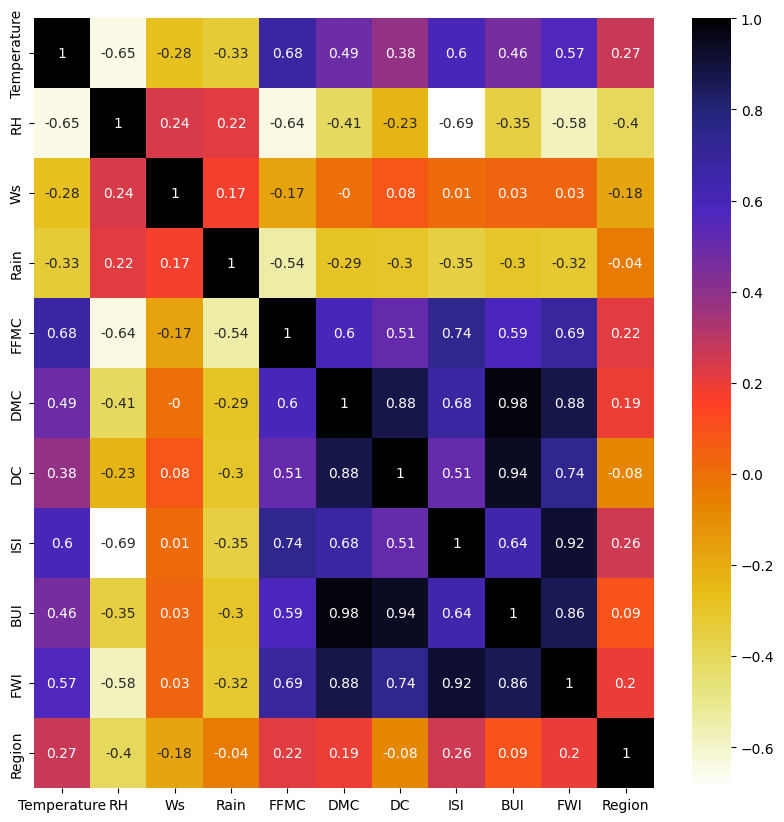

In [6]:
#Using Pearson Correlation
plt.figure(figsize=(10,10))
cor = round(X.corr(),2)
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

It looks like there is some correlation between some variables:
* BUI - Correlated with:
    * DMC
    * DC

* ISI - Correlated with:
    * FWI

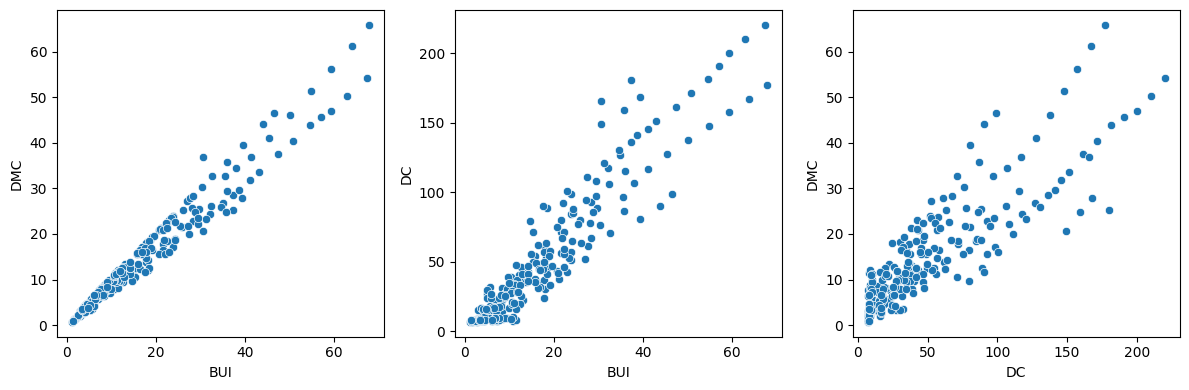

In [7]:

# Create a figure and a set of subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Adjust figsize for better spacing

sns.scatterplot(x=df['BUI'], y = df['DMC'], ax=axes[0])
sns.scatterplot(x=df['BUI'], y = df['DC'], ax=axes[1])
sns.scatterplot(x=df['DC'], y = df['DMC'], ax=axes[2])

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plot
plt.show()


#### VIF Analysis (Variance inflation factor)


In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

In [9]:
df_vif = df[['DMC', 'DC', 'BUI']]  # tus variables independientes
vif = pd.DataFrame()
vif['variable'] = df_vif.columns
vif['VIF'] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
print(vif)


  variable         VIF
0      DMC  177.399947
1       DC   47.616327
2      BUI  360.289670


These values indicate strong multicollinearity. Typically, a VIF above 10 suggests severe multicollinearity that may affect model performance and interpretability.



In [10]:
df[['DMC', 'DC', 'BUI']].corr()

,DMC,DC,BUI
DMC,1.000000,0.875925,0.982248
DC,0.875925,1.000000,0.941988
BUI,0.982248,0.941988,1.000000


Let's see which of the three variables is more correlated to the target variable

In [11]:
df[['DMC', 'DC', 'BUI','Classes']].corr()

,DMC,DC,BUI,Classes
DMC,1.000000,0.875925,0.982248,0.585658
DC,0.875925,1.000000,0.941988,0.511123
BUI,0.982248,0.941988,1.000000,0.586639
Classes,0.585658,0.511123,0.586639,1.000000


BUI has the highest correlation with the target variable, then this one will be used, DMC and DC will be dropped.

Now the FVI analysis for ISI and FWI

In [12]:
df_vif = df[['ISI', 'FWI']]  # tus variables independientes
vif = pd.DataFrame()
vif['variable'] = df_vif.columns
vif['VIF'] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
print(vif)


  variable        VIF
0      ISI  12.376134
1      FWI  12.376134


In [13]:
df[['ISI', 'FWI', 'Classes']].corr()

,ISI,FWI,Classes
ISI,1.000000,0.922895,0.735197
FWI,0.922895,1.000000,0.719216
Classes,0.735197,0.719216,1.000000


ISI has a higher correlation, then FWI will be dropped

In [14]:
#Dropping variables
X.drop(['DMC','DC', 'FWI'], axis=1, inplace=True) # First option

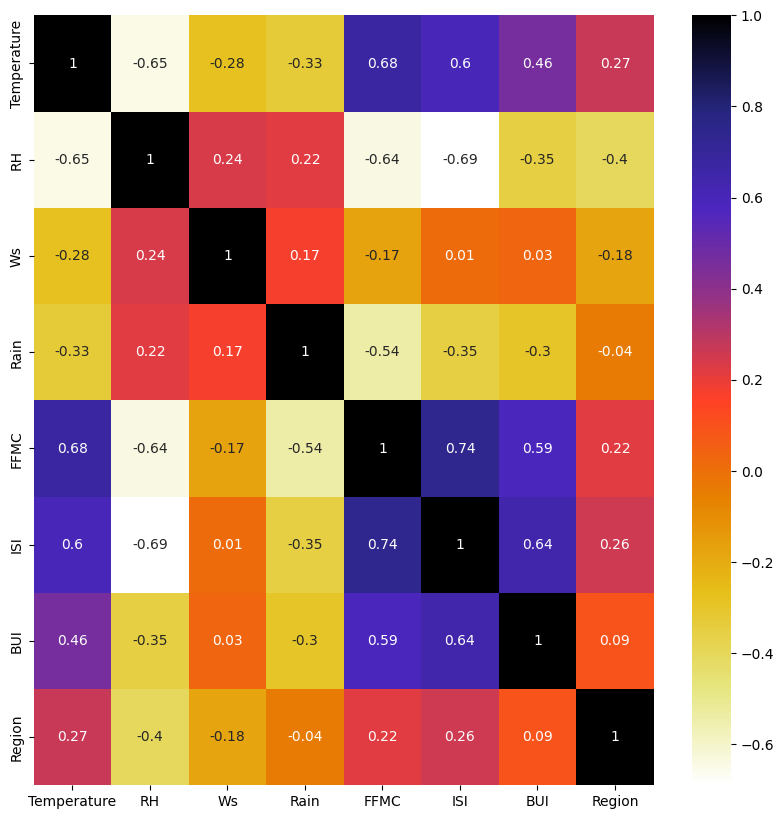

In [15]:
#Using Pearson Correlation
plt.figure(figsize=(10,10))
cor = round(X.corr(),2)
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

Now we can observe there are no more strong correlations between the "independent" variables to train the model.

### Feature scaling

In [16]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=36)

In [17]:
def scaler_standard(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled

In [18]:
X_train_scaled, X_test_scaled = scaler_standard(X_train, X_test)

Visualization to understand standard scaler

Text(0.5, 1.0, 'X_train After Scaling')

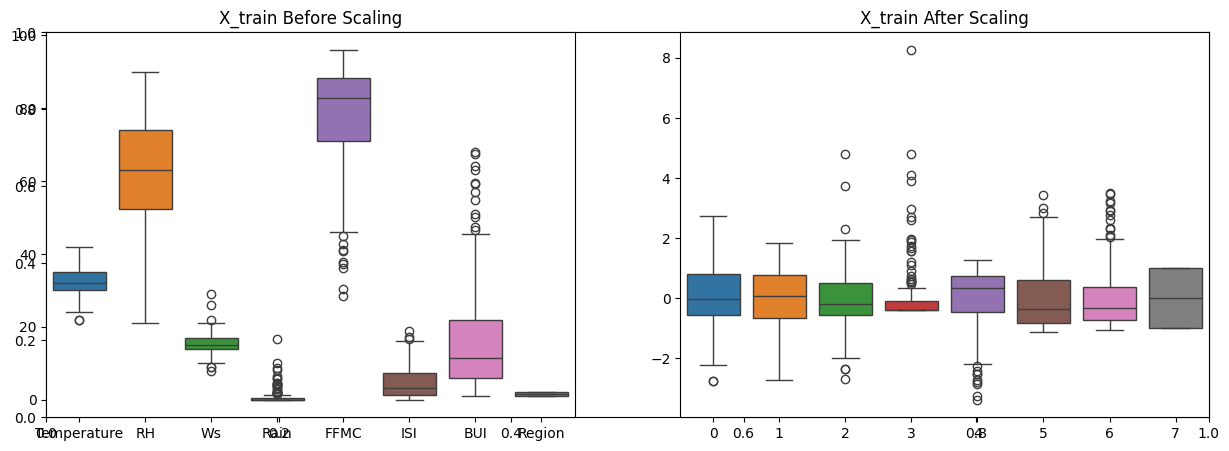

In [19]:
plt.subplots(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=X_train)
plt.title('X_train Before Scaling')
plt.subplot(1, 2, 2)
sns.boxplot(data=X_train_scaled)
plt.title('X_train After Scaling')

### Model selection

In [20]:
#Importing libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

#### Logistic regression

In [21]:
# Import Logistic Regression to Train from SKlearn
loreg = LogisticRegression(max_iter=2000)
loreg.fit(X_train,y_train)
loreg_pred = loreg.predict(X_test)
score = accuracy_score(y_test,loreg_pred)
cr = classification_report(y_test,loreg_pred)

print("Logistic Regression")
print ("Accuracy Score value: {:.4f}".format(score))
print (cr)

Logistic Regression
Accuracy Score value: 0.9388
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        17
           1       1.00      0.91      0.95        32

    accuracy                           0.94        49
   macro avg       0.93      0.95      0.93        49
weighted avg       0.95      0.94      0.94        49



#### Decision tree

In [22]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train_scaled,y_train)
dtc_pred = dtc.predict(X_test_scaled)
score = accuracy_score(y_test,dtc_pred)
cr = classification_report(y_test,dtc_pred)

print("Decision Tree")
print ("Accuracy Score value: {:.4f}".format(score))
print (cr)

Decision Tree
Accuracy Score value: 0.9592
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        17
           1       1.00      0.94      0.97        32

    accuracy                           0.96        49
   macro avg       0.95      0.97      0.96        49
weighted avg       0.96      0.96      0.96        49



#### Random forest

In [23]:
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled,y_train)
rfc_pred = rfc.predict(X_test_scaled)
score = accuracy_score(y_test,rfc_pred)
cr = classification_report(y_test,rfc_pred)

print("Random Forest")
print ("Accuracy Score value: {:.4f}".format(score))
print (cr)

Random Forest
Accuracy Score value: 0.9388
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        17
           1       1.00      0.91      0.95        32

    accuracy                           0.94        49
   macro avg       0.93      0.95      0.93        49
weighted avg       0.95      0.94      0.94        49



#### XGBoost Model

In [24]:
# Import KNeighborsClassifier to Train from SKlearn
xgb = XGBClassifier()
xgb.fit(X_train_scaled,y_train)
xgb_pred = xgb.predict(X_test_scaled)
score = accuracy_score(y_test, xgb_pred)
cr = classification_report(y_test, xgb_pred)

print("XGboost Classifier")
print ("Accuracy Score value: {:.4f}".format(score))
print (cr)

XGboost Classifier
Accuracy Score value: 0.9592
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        17
           1       1.00      0.94      0.97        32

    accuracy                           0.96        49
   macro avg       0.95      0.97      0.96        49
weighted avg       0.96      0.96      0.96        49



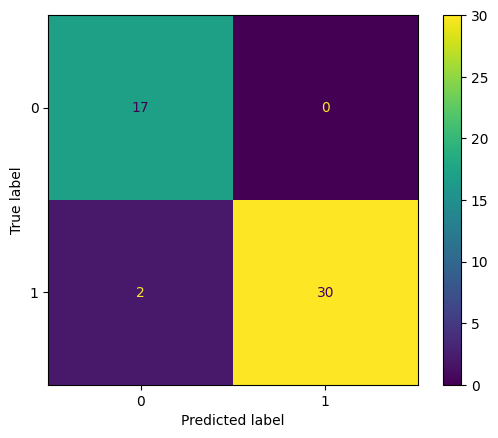

In [25]:
xgb_cm = ConfusionMatrixDisplay.from_estimator(xgb, X_test_scaled, y_test)

**Accuracy score Results Summary**

| Models     | Accuracy score  |
| ----------- | ----------- |
| XGboost classifier     | 95.92 % |
| Decision Tree Classifier  | 95.92% |
| Logistic Regression Accurracy  | 93.88 % |
| Random Forest Classifier  | 93.88 % |

#### Applying Stratified KFold Cross-Validation

In [26]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
skfold = StratifiedKFold(n_splits= 10,shuffle= True,random_state= 36)

In [27]:
cv_xgb= cross_val_score(xgb,X,y,cv=skfold,scoring='accuracy').mean()
print('CV Score XGB Tuned {:.4f}'.format(cv_xgb))

CV Score XGB Tuned 0.9877


In [28]:
cv_dt =cross_val_score(dtc,X,y,cv= skfold,scoring="accuracy").mean()
print('CV Score Decision Tree {:.4f}'.format(cv_dt))

CV Score Decision Tree 0.9710


### Feature importance

In [34]:
feature_importances = xgb.feature_importances_
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importances
}).sort_values('importance', ascending=False)


In [35]:
importance_df

,feature,importance
4,FFMC,0.668793
5,ISI,0.315075
1,RH,0.007339
0,Temperature,0.004610
6,BUI,0.004183
2,Ws,0.000000
3,Rain,0.000000
7,Region,0.000000


### Conclusions

After performing some exploratory data analysis, it was observable that there were different behaviours of the different variables when there was fire and when there wasn't.

For training the model, it was observed that there were some variables that were correlated with each other, mainly:
* DMC, DC & BUI (in one group)
* FWI & ISI (in another group)

A Variance Inflation Factor Analysis was applied to verify if there was multicollinearity, and it was discovered that there was really a multicollinearity problem. So it was decided to remove the following "independent" variables, as we kept the variables that had higher correlations with the target variable.
* DMC
* DC
* FWI

A standardization process was applied to bring all the variables into similar ranges, as there were different ranges for the independent variables, in order to obtain a better performance.

Once we trained the model, we saw very good results with different algorithms and the best were:
* XGBoost
* Random forest

XGBoost showed the best accuracy score in the Stratified K-Fold cross-validation step, used because of possible class imbalance. While accuracy was the primary metric, precision and recall could be used to obtain a better understanding of the models' performance.

Finally, after observing the feature importance, FFMC has the highest value, and taking a look at the histogram by Fire / Not fire, we can understand why it has the highest "Feature importance" value; it's clearly observable that for values above 82.5, there is more probability of Fire.

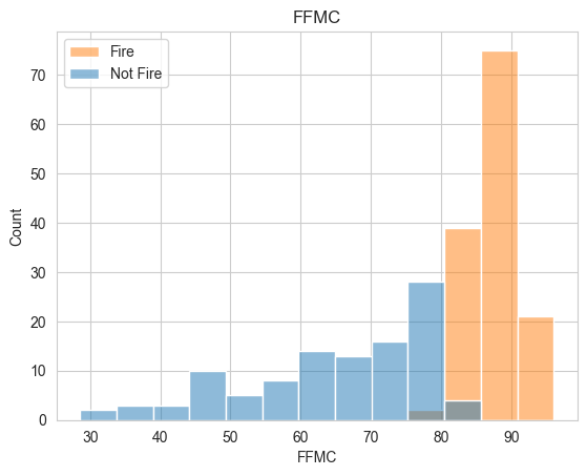